In [261]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [262]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
#train_data_path = join('../input', 'train.csv')
#sub_data_path = join('../input', 'test.csv')
#!ln -s ~/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data
#!ls ~/aiffel/kaggle_kakr_housing/data

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

#### 베이스라인 이후 개량

1. 목표값 prize의 분석과 로그변환, 이상치 제거

In [264]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [265]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [266]:
money = pd.read_csv(train_data_path) #손상되지않은 훈련값 데이터 새로 불러오기

In [267]:
for c in money.columns: #결측치 수 확인
    print('{} : {}'.format(c, len(money.loc[pd.isnull(money[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


<AxesSubplot:xlabel='price', ylabel='Density'>

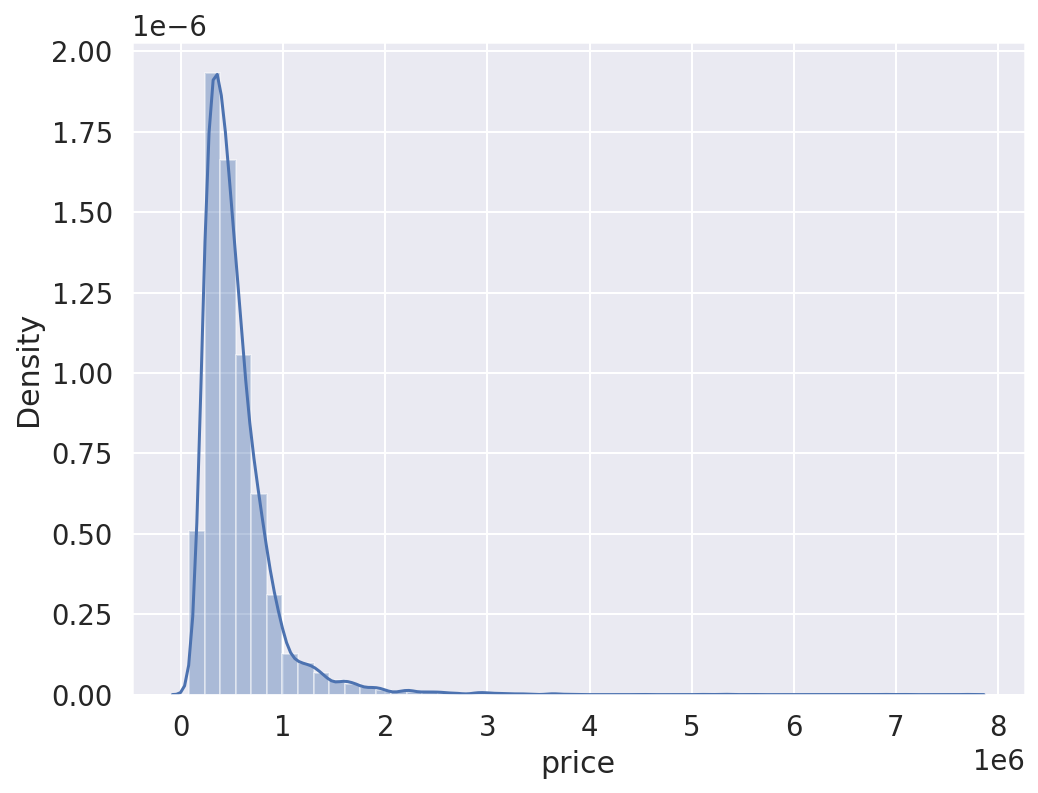

In [268]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(money['price'])

값이 치우쳐져 있어 로그변환으로 정규 분포로 전환

<AxesSubplot:xlabel='price', ylabel='Density'>

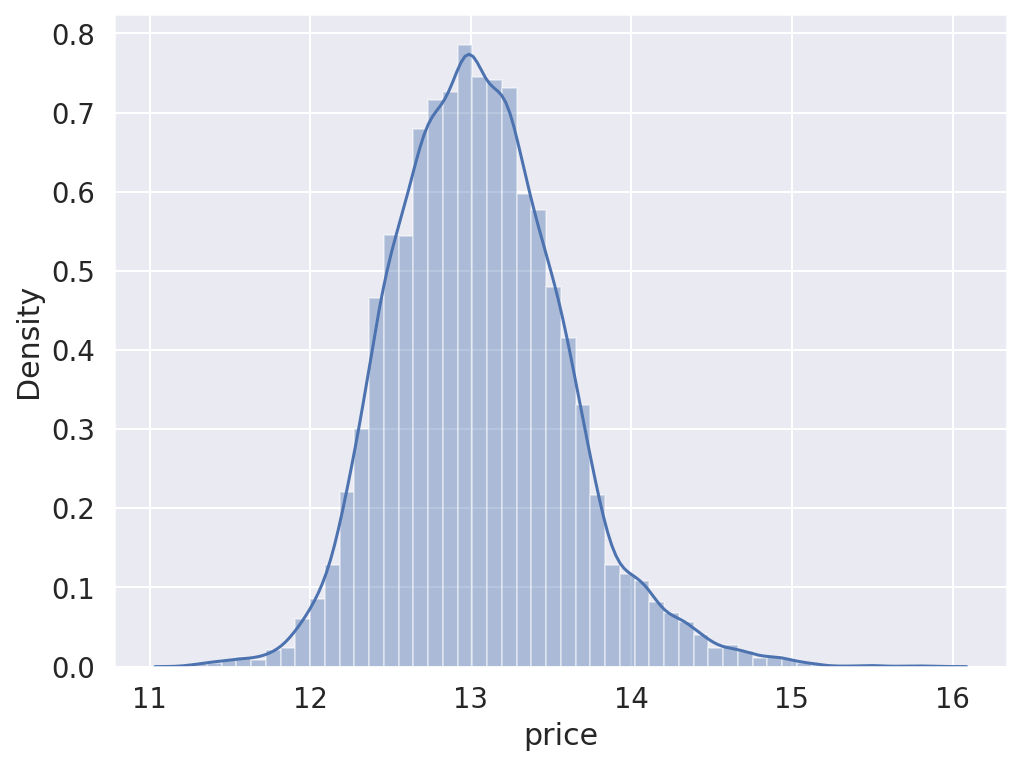

In [269]:
money['price'] = np.log1p(money['price']) #
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(money['price'])

목표값 y분석
목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵
https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12 참조

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

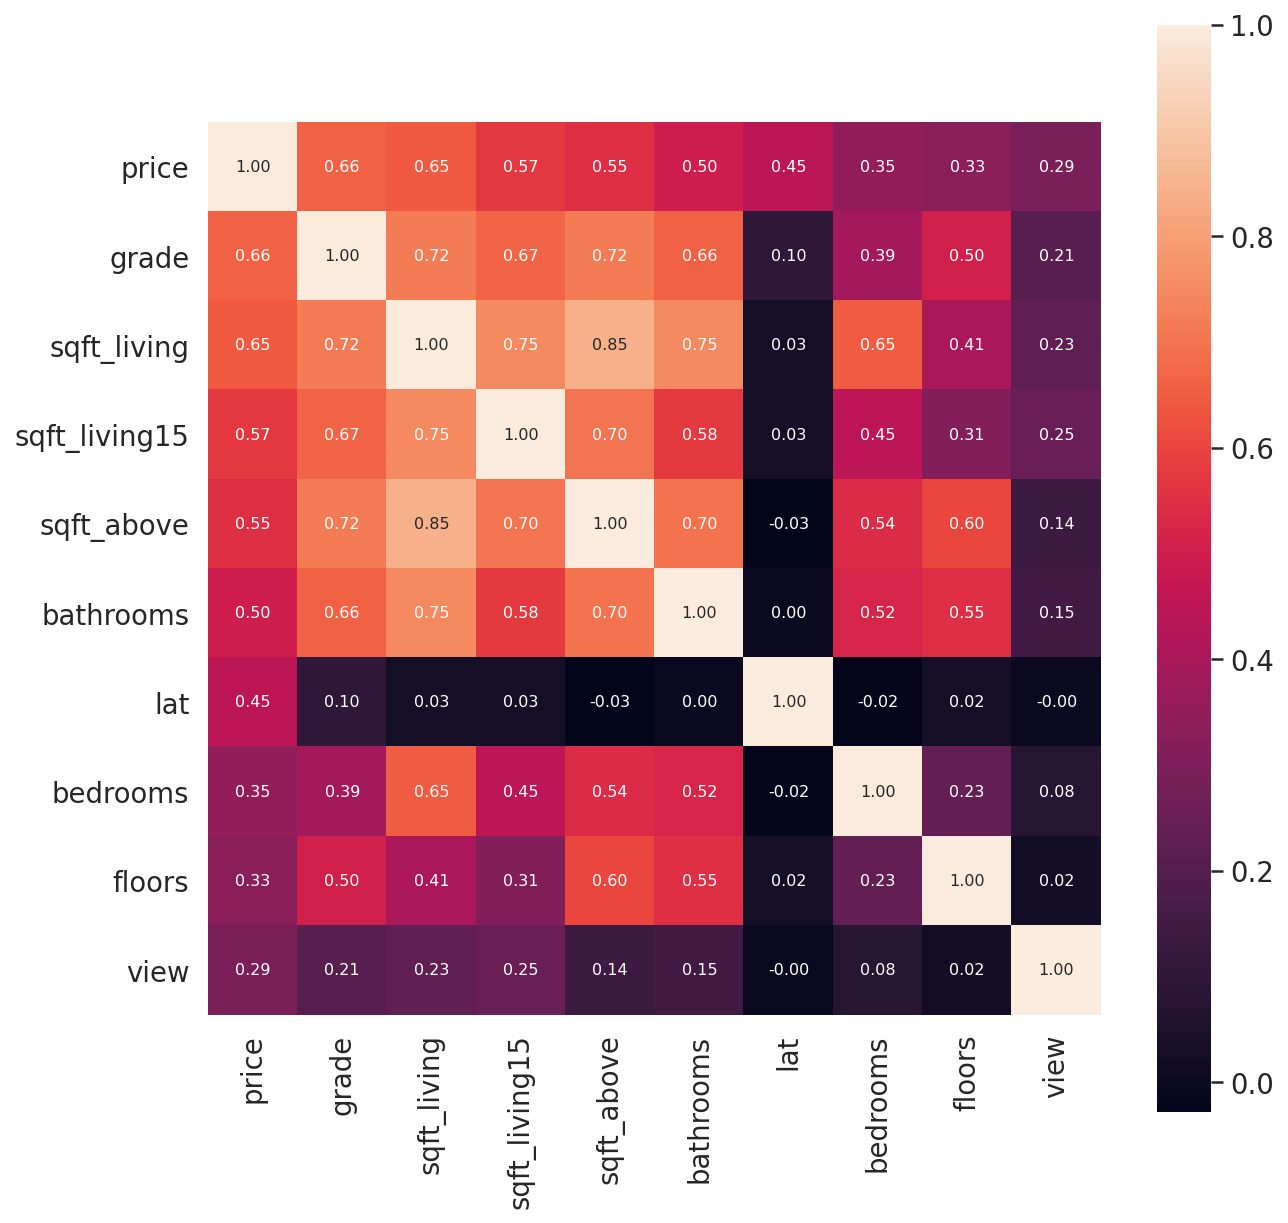

In [270]:
import scipy as sp



cor_abs = abs(money.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(money[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, \
            square=True , annot_kws={'size' : 8} , \
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

['grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view'] 순으로 가격과 상관 관계가 크다


#### grade(집등급)

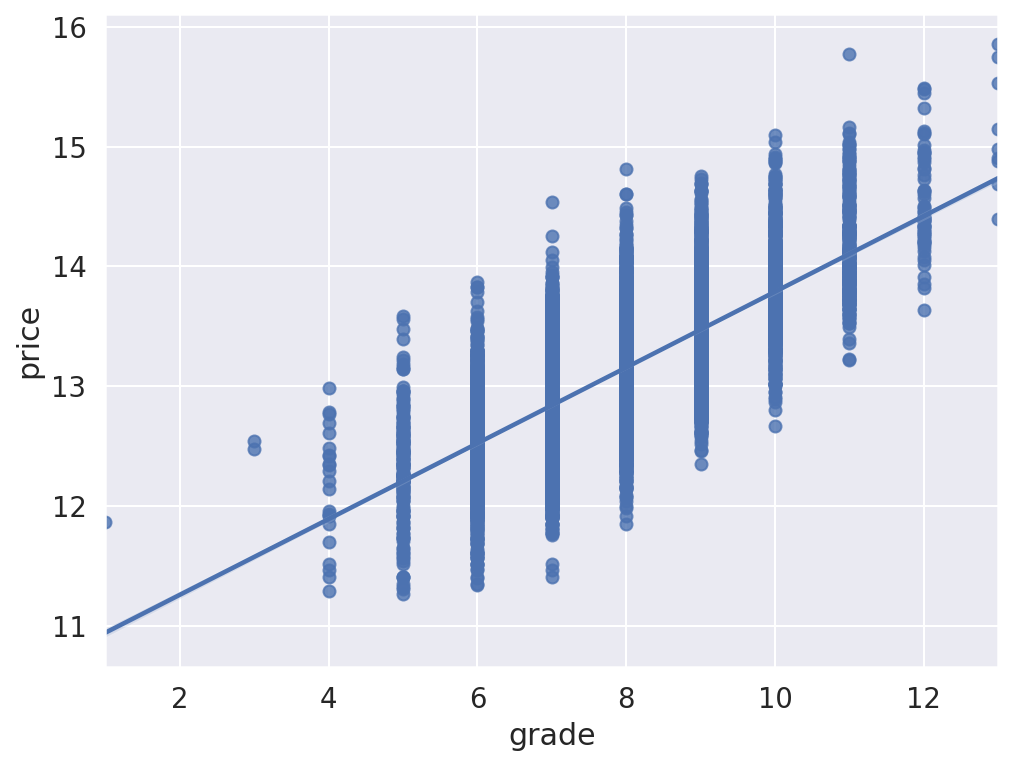

In [271]:
data = pd.concat([money['price'], money['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='grade', y="price", data=data)

먼저 grade의 경우 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 라고 합니다.

In [272]:
money.loc[(money['price']>15.5) &(money['grade']== 11)]
#11의 이상치가 눈에 띄는 군요 
# 이상치는 2775번으로 보이는데 워터프론트도 있긴 한데 학습에 방해될꺼같으니 삭제합니다


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [273]:
money = money.loc[money['id']!=2775]

In [274]:
money.loc[(money['grade'] <= 3)]
# grade 3이하의 예시는 3개 뿐이고 평균을 형성하기 어려울 정도라 학습을 위해 제거

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
13522,13522,20140926T000000,11.863589,0,0.00,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [275]:
money = money.loc[money['id']!=2302]
money = money.loc[money['id']!=4123]
money = money.loc[money['id']!=13522]

In [276]:
money.loc[(money['price']>14.7) & (money['grade'] == 8)]
#8등급 이상치도 거슬림

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [277]:
money = money.loc[money['id']!=7173]

In [278]:
money.loc[(money['price']>14.5) & (money['grade'] == 7)]
# 7등급 위도 제거

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [279]:
money = money.loc[money['id']!=12346]

In [280]:
money.loc[(money['price']<11.6) & (money['grade'] == 7)]
# 7등급 아래도 제거

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
878,878,20140717T000000,11.512935,2,1.0,770,17334,1.0,0,0,...,7,770,0,1978,0,98001,47.2997,-122.269,1480,17334
2372,2372,20141212T000000,11.461643,2,1.0,800,8550,1.0,0,0,...,7,800,0,1947,0,98198,47.4075,-122.294,1490,8550
8756,8756,20140513T000000,11.407576,2,1.0,790,2640,1.0,0,0,...,7,790,0,1973,0,98034,47.7351,-122.178,1310,2064


In [281]:
money = money.loc[money['id']!=878]
money = money.loc[money['id']!=2372]
money = money.loc[money['id']!=8756]

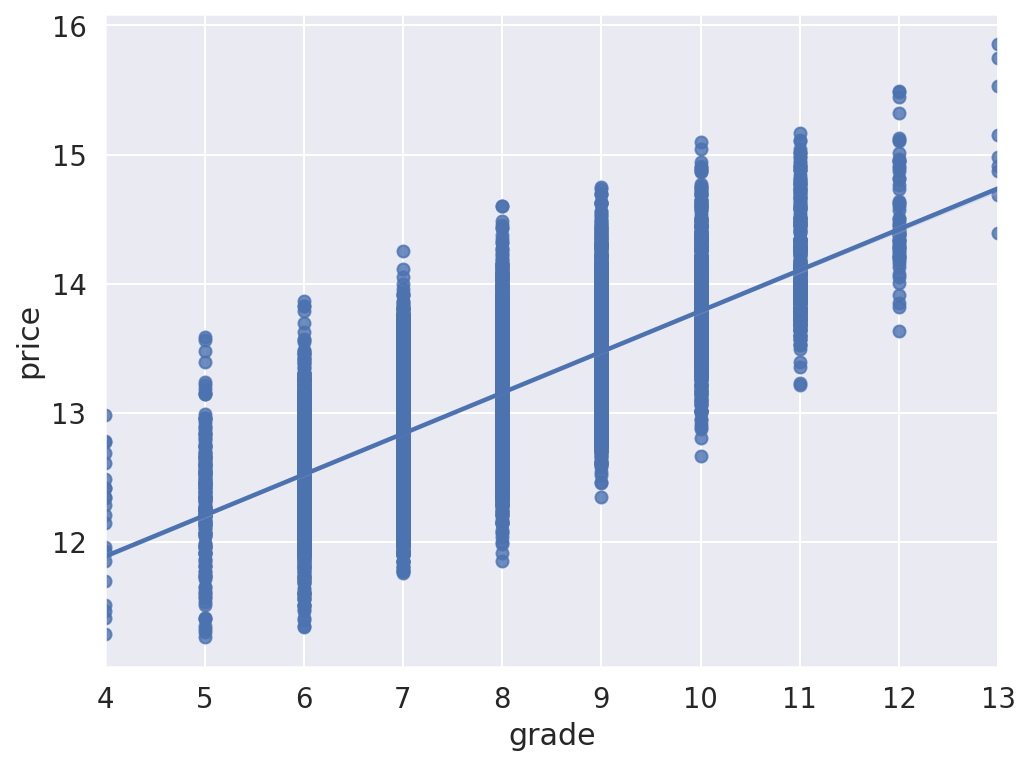

In [282]:
data = pd.concat([money['price'], money['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='grade', y="price", data=data)
#등급 그래프 다시보기

음 좀 맘에들게 깨끗해졌네요
***

#### sqft_living (주거 공간의 평방 피트)

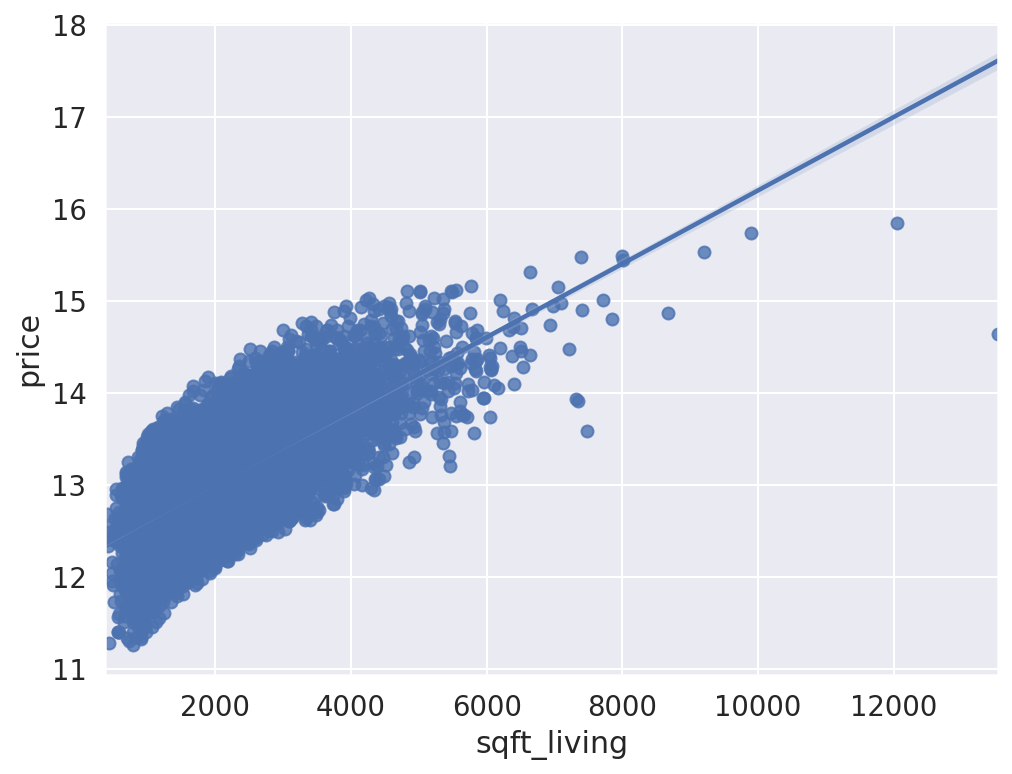

In [283]:
data = pd.concat([money['price'], money['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [284]:
money.loc[money['sqft_living']>13000]
#이상치인가 봤더니 13000짜리는 sqft_lot이 엄청 넓군요 (부지의 평방 피트)
#하지만 학습에 방해가 되니 지우기로 하겠습니다.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [285]:
money = money.loc[money['id']!=8912]

***
#### bedrooms(침실)

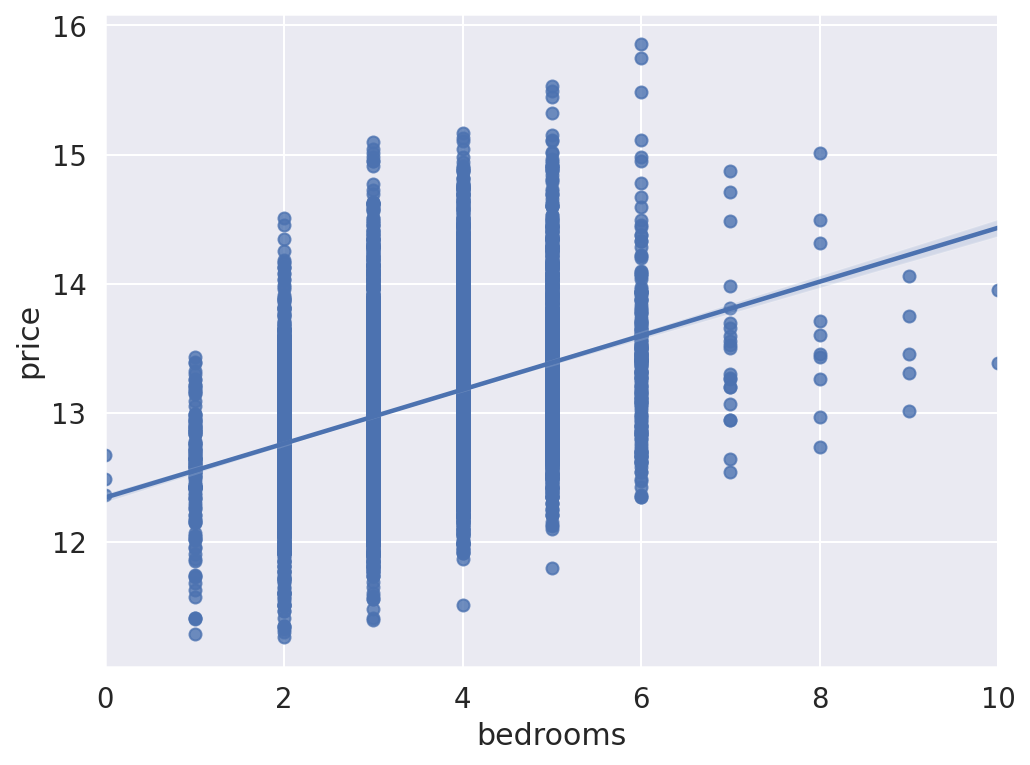

In [286]:
data = pd.concat([money['price'], money['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='bedrooms', y="price", data=data)

음 선형적으로 많이 벗어나지 않아서 제거는 없습니다
***
#### lat(위도값)

![image](https://user-images.githubusercontent.com/81237366/137259662-12351af3-718c-443c-822c-118c745d0cc8.png)   
 lat은 위도 값인데 참고자료에 따르면 시애틀이 자료인데 북쪽으로 갈수록 고가의 집단지가 많다고 한다

In [287]:
# train = money #전처리 값을 반영
#train = pd.read_csv(train_data_path)
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')
#전처리 했던거 다시 뺸 기록

얍💢


In [288]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [289]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [290]:
y = train['price']
del train['price']

print(train.columns)

del train['id']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [291]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [292]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

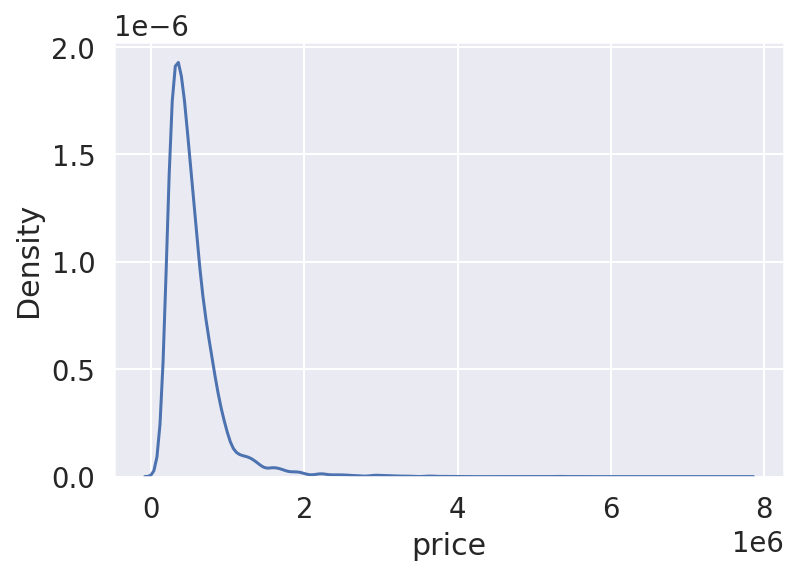

In [293]:
sns.kdeplot(y)
plt.show()


In [294]:
y = np.log1p(y)

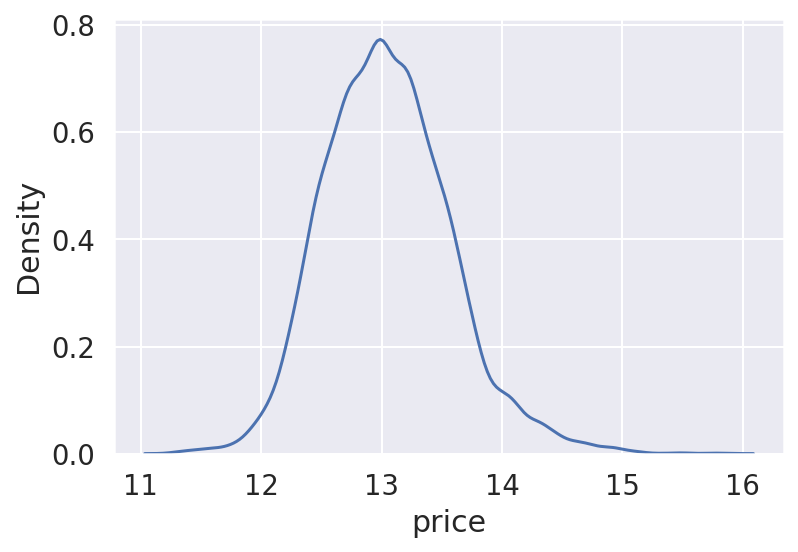

In [295]:
sns.kdeplot(y)
plt.show()

In [296]:
"""fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        #ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break"""

'fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. \n\n# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.\ncount = 1\ncolumns = train.columns\nfor row in range(9):\n    for col in range(2):\n        sns.kdeplot(train[columns[count]], ax=ax[row][col])\n        #ax[row][col].set_title(columns[count], fontsize=15)\n        count += 1\n        if count == 19 :\n            break'

In [297]:
"""skew_columns = ['sqft_lot15', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
#정규화가 필요해보이는 것들 정규화
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)"""

"skew_columns = ['sqft_lot15', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']\n#정규화가 필요해보이는 것들 정규화\nfor c in skew_columns:\n    train[c] = np.log1p(train[c].values)\n    test[c] = np.log1p(test[c].values)"

In [298]:
"""fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 6:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
       # ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

"""

'fig, ax = plt.subplots(3, 2, figsize=(10, 15))\n\ncount = 0\nfor row in range(3):\n    for col in range(2):\n        if count == 6:\n            break\n        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])\n       # ax[row][col].set_title(skew_columns[count], fontsize=15)\n        count+=1\n\n'

In [299]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

#### 변수추가
를 사실 다른 자료에서 보고 사용하려 했으나 이해가 덜되서 사용 안함

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [301]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [302]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [303]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=7777        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [304]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df
  
get_scores(models, train, y) #결과로 xgb가 제일 좋다 였는데 돌리다보니 그레디언트가 좋덴다

,RMSE
RandomForestRegressor,143684.884927
GradientBoostingRegressor,141173.883705
XGBRegressor,124764.241264
LGBMRegressor,119486.485219


### 그리드 탐색

In [305]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


[스코어링 종류](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)


In [306]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [307]:
param_grid = {
    'n_estimators': [500], #부스팅 스테이지 수
    'learning_rate': [0.05], #eta 훈련량 미세하게 하면 오래 걸림
    'max_depth': [10], #나무 깊이 디폴트 -1로 제한없이 분기
  #  'colsample_bytree': [0.9], #열 샘플링 - 열에 대한 샘플링을 통해 다양성을 높인다
    'subsample': [0.8] # 데이터를 일부 발췌해서 다양성을 높임
}
#파라메터가 훨씬 많았는데 xgb 하나 돌리고 4시간 기다려본 결과로 돌리기로 했다
#xgb는 시간이 너무 오래걸려서 다시는 못돌릴꺼 같다 나온 하이퍼 파라미터 값만 사용해야..
#model = LGBMRegressor(random_state=random_state) 기본값 말고 결과가 좋은 xgb로
model = GradientBoostingRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
results

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.5min finished


,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
0,0.05,10,500,0.8,-0.028069,0.167537


In [308]:
param_grid = {
    'n_estimators': [500], #부스팅 스테이지 수
    'learning_rate': [0.05], #eta 훈련량 미세하게 하면 오래 걸림
    'max_depth': [10], #나무 깊이 디폴트 -1로 제한없이 분기
  #  'colsample_bytree': [0.9], #열 샘플링 - 열에 대한 샘플링을 통해 다양성을 높인다
    'subsample': [0.8] # 데이터를 일부 발췌해서 다양성을 높임
}
#파라메터가 훨씬 많았는데 xgb 하나 돌리고 4시간 기다려본 결과로 돌리기로 했다
#xgb는 시간이 너무 오래걸려서 다시는 못돌릴꺼 같다 나온 하이퍼 파라미터 값만 사용해야..
model = LGBMRegressor(random_state=random_state) #기본값 말고 결과가 좋은 xgb로
#model = GradientBoostingRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
results

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.0s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
0,0.05,10,500,0.8,-0.025927,0.16102


In [309]:
gb_best = GradientBoostingRegressor(learning_rate=0.05, max_depth=10, n_estimators=500,subsample=0.8, random_state=random_state)
gb_best.fit(train, y)
gb_best_pred = gb_best.predict(test)

In [310]:
prediction = np.expm1(gb_best_pred)
prediction

array([ 479271.13256794,  482813.02123061, 1320956.27794333, ...,
        484371.58773433,  319769.32254697,  446927.95861767])

In [319]:
lgbm_best = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=500,subsample=0.8, random_state=random_state)
lgbm_best.fit(train, y)
lgbm_best_pred = lgbm_best.predict(test) # lgbm

In [312]:
#abs(grid_model.best_score_) #lgbm 값

In [313]:
#grid_model.best_params_ #lgbm 값

In [320]:
lgbm_best_pred

array([13.07368107, 13.09170761, 14.14209656, ..., 13.08250305,
       12.69985248, 12.96820835])

In [321]:
prediction = np.expm1(lgbm_best_pred)
prediction

array([ 476240.8402216 ,  484903.67768145, 1386226.45945987, ...,
        480460.82171205,  327698.55645539,  428568.56542495])

In [316]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
# 코드 작성

In [322]:
save_submission(lgbm_best, train, y, test, 'lgbm', rmsle='0.16102')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.16102.csv saved!


***
## 결과물 112663

![image](https://user-images.githubusercontent.com/81237366/137895008-d58add1a-a21e-4d77-b47c-ebf58f372e12.png)


✓ 튜닝해볼 수 있는 모델 클래스 인자

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

    max_depth : 의사 결정 나무의 깊이, 정수 사용
    learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
    n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
    num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
    boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

위에서 저는 n_estimators와 max_depth 에 대해서만 아주 간단하게 실험했지만, 훨씬 더 다양하게 실험을 하며 최적의 조합을 찾아볼 수 있습니다.
실제로 lightgbm에 넣을 수 있는 인자는 아래 자료들에서 설명하는 것처럼 매우 다양합니다.

    lightGBM / XGBoost 파라미터 설명
    Chapter 4. 분류 - LightGBM 

위의 자료 외에도 lightgbm, xgboost 하이퍼 파라미터 튜닝 키워드로 검색해보면 다양한 하이퍼 파라미터의 종류를 확인할 수 있습니다.

실험 과정에서는 물론 위에서 만들었던 my_GridSearch(), save_submission() 등의 함수를 사용해도 되고, 혹은 여러분이 원하는 새로운 함수를 만들어서 사용해도 됩니다!
✓ 시도해볼 수 있는 방법

여러분이 시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

    기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
    LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
    다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
    Baseline 커널에서 활용했던 블렌딩 방법 활용하기 

물론 이 외에도 좋은 아이디어가 있다면 당연히 시도해보는 것도 좋습니다. 자유롭게 여러 가지 방법을 활용해서 점수를 끌어올려 보세요!
참고로, 진행하면서 도움이 될 수 있는 가장 좋은 자료는 이미 대회를 진행한 사람들이 올려둔 커널입니다.

    https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks

아주 다양하게 데이터를 탐색해 본 커널도 있고, 상위권을 달성한 커널은 오늘 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 합니다. 한 번씩 구경해보고 다른 사람들은 어떤 전략으로 성능을 끌어올렸는지 공부해보는 것도 매우 좋을 겁니다!

여러 가지 실험을 해보고 결과 csv는 캐글에, 사용한 노트북은 깃허브(GitHub)를 통해 이곳에 제출해 주세요. 제출한 노트북에는 본인의 캐글 Submission 스코어를 기재해 주시기 바랍니다.

그럼, 시작해보죠! 화이팅!!! 💪🏼
프로젝트 루브릭

- 1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
	데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.

- 2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
        제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이체계적으로 기술되었다.

- 3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
	다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

## 회고
열심히 전처리하고 열심히 코드바꿔가며 개조한 버젼이 58만점이 나왔다(순정이 115688인데)
뭔가 잘못된거 같아서 열심히 캐글의 다른 분들 것을 참조한 결과 데이터 전처리 및 데이터의 활용을 고려하는 EDA가 중요하단 것을 배웠다. 

뜯어고친거가 연구를 해도 답이 안나와서 순정으로 돌아갑니다 ㅠ 결코 연구를 안한게 아닙니다 (5일간 봤어요ㅠ)

grid_search에서 원래는 파라미터가 많았으나 xgb에서 깡으로 기다려본결과 4시간이 넘게 걸려서 더느린 그레디언트부스팅은 변수 하나로만 돌렸다..

전처리한게 결과가 안나와서 익스 순정 전처리만 다시 했습니다 ㅠ
112633으로 도전을 마칩니다. 너무 안되니 힘드네요 ㅠ